<a href="https://colab.research.google.com/github/brianmiyatake/conformal-prediction-covariate-shift/blob/main/covariate_shift_quantile_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conformalized Quantile Regression with Covariate Shift

Conformal prediction is a framework that can be applied to predictive models to output sets or intervals that achieve a user-chosen error rate under the assumption of exchangeability in the data. We assume familiarity with general techniques of conformal prediction without covariate shift, as in chapters 1 and 2 of [1]. While these techniques are concrete under "nice" conditions, the assumption of exchangeability may fail when the data has undergone a covariate shift.

A covariate shift occurs when the input data $X$ differs between training and testing time, but the conditional distribution of $Y\mid X$, the response when conditioned on the input, remains unchanged. More formally, we assume that the training data comes from a distribution $\mathscr{P}$, the testing data comes from a distribution $\mathscr{P}_{\text{test}}$, and $\mathscr{P}(Y\mid X)=\mathscr{P}_{\text{test}}(Y\mid X)$.

We require $\mathscr{P}_{\text{test}}$ to be absolutely continuous with respect to $\mathscr{P}$, i.e., if a set $A$ is $\mathscr{P}$-null, then it is also $\mathscr{P}_{\text{test}}$-null. This is an intuitive idea, for if the support of $\mathscr{P}_{\text{test}}$ is not contained in the support of $\mathscr{P}$, then it is surely impossible that a reasonable prediction set/interval can be fit on some input $x$ that lies in the support of $\mathscr{P}_{\text{test}}$, but not in the support of $\mathscr{P}$. Under this assumption, we obtain the existence of the Radon-Nikodym derivative
$$
w(x)=\frac{\mathrm{d}\mathscr{P}_{\text{test}}}{\mathrm{d}\mathscr{P}}(x),
$$ called the likelihood ratio.

Given knowledge of the distributions $\mathscr{P}$ and $\mathscr{P}_{\text{test}}$ beforehand, the likelihood ratio can oftentimes be directly calculated via taking the ratio of the probability density functions of $\mathscr{P}_{\text{test}}$ and $\mathscr{P}$, respectively. This is sometimes infeasible, and this is the assumption we make in our conformal prediction algorithm, following the approach in [2]. We create feature-pairs $(X_i, C_i)$ of both training and testing data, where $C_i=1$ if $X_i$ is from the training data and $C_i=0$ if $X_i$ is from the testing data. We then train a multilayer perceptron on our feature-pairs using Keras/Tensorflow to approximate the probability
$$
\widehat{p}(x)=P(C=1\mid X=x).
$$ Observe now that
$$
w(x)=\frac{P(C=0)}{P(C=1)}\cdot \frac{P(C=1)P(X=x\mid C=1)}{P(C=0)P(X=x\mid C=0)}=\frac{P(C=0)}{P(C=1)}\cdot\frac{P(C=1\mid X=x)}{P(C=0\mid X=x)}
$$ by an application of Bayes' Theorem. Normalization constants turn out to be negligible in our later calculations, so we can directly take
$$
w(x)=\frac{P(C=1\mid X=x)}{P(C=0\mid X=x)}=\frac{\widehat{p}(x)}{1-\widehat{p}(x)}
$$ as the approximation for our likelihood function.

Using the approximated likelihood ratio, we now show the algorithm for performing conformalized quantile regression when there is a covariate shift. Given a user-chosen error rate $\alpha$, we train two gradient boosting models on a weighted quantile loss objective function on the training data $X_\text{train}$ to estimate the $\alpha/2$ and $1-\alpha/2$ quantiles of $Y\mid X=x$, for all $x\in X_{\text{train}}$. We denote these learned quantiles as $\widehat{t}_{\alpha/2}(x)$ and $\widehat{t}_{1-\alpha/2}(x)$, respectively. For a calibration point $(X_\text{cal}, Y_\text{cal})$, we define its score as
$$
s(X_\text{cal}, Y_\text{cal})=\max(\widehat{t}_{\alpha/2}(x)-Y_\text{cal}, Y_\text{cal}-\widehat{t}_{1-\alpha/2}(x)).
$$ Doing this for all $n$ calibration points, we obtain scores $s_1,\dots, s_n$, which we assume are already in sorted order. Define
$$
\widehat{q}(x)=\inf\left\{s_j:\sum_{i=1}^j p_i^w(x)\mathbb{I}_{\{s_i\leq s_j\}}\geq 1-\alpha \right\}
$$ where
$$
p_i^w(x)=\frac{w(X_i)}{\sum_{j=1}^n w(X_j)+w(x)},
$$ for $1\leq i\leq n$, with $X_1,\dots, X_n$ being the calibration data. We then obtain our prediction interval as
$$
C(x)=\left\{y: s(x,y)\leq \widehat{q}(x)\right\}=\left[\widehat{t}_{\alpha/2}(x)-\widehat{q}(x), \widehat{t}_{1-\alpha/2}(x)+\widehat{q}(x)\right],
$$ as desired. Note that these weights are actually dependent on $x$, so for every $x$ that we sample, we may observe a different width for each prediction interval. This makes sense, since we should be more/less confident based on the proximity of our input $x$ to our training/calibration data and is the reason that the weights $p_i^w$ are calculated in the manner above.

## Sources
[1] Angelopoulos, A. N., & Bates, S. (2022). A gentle introduction to conformal prediction and distribution-free uncertainty quantification. arXiv. https://arxiv.org/abs/2107.07511

[2] Tibshirani, R. J., Barber, R. F., Candès, E. J., & Ramdas, A. (2020). Conformal prediction under covariate shift. arXiv. https://arxiv.org/abs/1904.06019


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.ensemble import GradientBoostingRegressor

In [20]:
# true function for producing simulated data
def true_fun(x):
  return (3*x+1) / (x ** 2 + 1) + x ** 2

In [21]:
# simulated data for now

# choose two distributions, one distribution P for training and calibration, one distribution P_test for testing
# will use two normal distributions with different scalings
mu_train = 10
sigma_train = 4

mu_test = 6
sigma_test = 1

# assume some measurement error normally distributed with mean 0 and following sd:
measurement_error = 100

# size of training and testing data
size_of_training = 20000
size_of_testing = 4000

X = mu_train + np.random.randn(size_of_training, 1) * sigma_train
y = true_fun(X) + measurement_error * np.random.randn(size_of_training, 1)
y = y.ravel()

X_test = mu_test + sigma_test * np.random.randn(size_of_testing, 1)
y_test = true_fun(X_test) + measurement_error * np.random.randn(size_of_testing, 1)
y_test = y_test.ravel()

sample_points = np.linspace(np.min(X_test), np.max(X_test), 1000)

X_min = np.min(X, axis=0)
X_max = np.max(X, axis=0)

# calibration set size is 500
X_train, X_cal, y_train, y_cal = train_test_split(X, y, test_size=500, random_state=0)
n = X_cal.shape[0]

# user-chosen error rate, if too small then no points will fall outside interval
error_rate = 0.25

In [22]:
# compute Wasserstein distance from distributions P and P_test
# shared histogram bins
number_of_bins = 200
combined_min = float(min(X_train.min(), X_test.min()))
combined_max = float(max(X_train.max(), X_test.max()))
bin_edges = np.linspace(combined_min, combined_max, number_of_bins + 1)
bin_width = bin_edges[1] - bin_edges[0]

# probability mass per bin
training_counts, _ = np.histogram(X_train, bins=bin_edges)
testing_counts,  _ = np.histogram(X_test,  bins=bin_edges)

if training_counts.sum() == 0 or testing_counts.sum() == 0:
    emd_train_vs_test = 0.0
else:
    training_mass = training_counts / training_counts.sum()
    testing_mass  = testing_counts  / testing_counts.sum()

    # scan/flow update (bins are zero-indexed)
    cumulative_flow = 0.0
    emd_train_vs_test = 0.0
    for i in range(number_of_bins):
        cumulative_flow = training_mass[i] + cumulative_flow - testing_mass[i]
        emd_train_vs_test += abs(cumulative_flow) * bin_width

print(f"Wasserstein distance between training and testing distributions: {emd_train_vs_test}")

Wasserstein distance between training and testing distributions: 4.236508391773081


In [23]:
# need to estimate the likelihood ratio between our two distributions, in the general case
# can train a classifier model to estimate P(X in original dist|X=x), which can then be used to approximate the likelihood ratio
# try using a multilayer perceptron with 1 output node

X_pooled = np.vstack([X_train, X_test])
c_pooled = np.hstack((np.zeros(X_train.shape[0]), np.ones(X_test.shape[0])))
X_tr, X_val, c_tr, c_val = train_test_split(X_pooled, c_pooled, test_size=0.1, random_state=0)

d = X_pooled.shape[1]
inputs = keras.Input(shape=(d,))
x = keras.layers.Dense(64, activation="relu")(inputs)
x = keras.layers.Dense(64, activation="relu")(x)
output = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, output)

pos = c_tr.mean()
class_weight = {0: 0.5 / (1 - pos + 1e-12), 1: 0.5 / (pos + 1e-12)}

model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=[keras.metrics.AUC(name="auc"), "accuracy"])

callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)]
model.fit(X_tr, c_tr, validation_data=(X_val, c_val), epochs=200, batch_size=256, verbose=0, callbacks=callbacks)

In [24]:
# the likelihood ratio between can now be approximated:
def likelihood_ratio(x):
  p = model.predict(x, verbose = 0) - 10**-6
  return p / (1 - p)


In [25]:
# create models that predict quantiles using quantile loss
gb_left_quantile = GradientBoostingRegressor(
    loss="quantile",
    alpha=error_rate/2,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.7,
    random_state=0,
)
gb_right_quantile = GradientBoostingRegressor(
    loss="quantile",
    alpha=1 - error_rate/2,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.7,
    random_state=0,
)

w_tr = likelihood_ratio(X_train).ravel()
gb_left_quantile.fit(X_train, y_train, sample_weight=w_tr)
gb_right_quantile.fit(X_train, y_train, sample_weight=w_tr)

GradientBoostingRegressor(alpha=0.875, learning_rate=0.05, loss='quantile',
                          random_state=0, subsample=0.7)

In [26]:
# predict quantiles
y_pred_left_cal  = gb_left_quantile.predict(X_cal)
y_pred_right_cal = gb_right_quantile.predict(X_cal)
cal_scores = np.maximum(y_cal - y_pred_left_cal, y_pred_right_cal - y_cal)

w_cal = likelihood_ratio(X_cal).ravel()
order = np.argsort(cal_scores)
s_sorted = cal_scores[order]
w_sorted = w_cal[order]
sum_w = w_sorted.sum()
cw = np.cumsum(w_sorted) / sum_w

# compute qhat (which is dependent on testing point x)
def find_qhat(s_sorted, cw, sum_w, x, error_rate):
    w_test = float(likelihood_ratio(np.asarray(x).reshape(1, -1)))
    target = (1.0 - error_rate) * (sum_w + w_test) / sum_w
    target = min(max(target, 0.0), 1.0)
    j = np.searchsorted(cw, target, side="left")
    if j >= len(s_sorted): j = len(s_sorted) - 1
    return s_sorted[j]

# create prediction intervals around each sampling point
x_grid = np.asarray(sample_points).reshape(-1, 1)
y_true_grid = true_fun(x_grid).ravel()
y_sim = y_true_grid + measurement_error * np.random.randn(y_true_grid.shape[0])
qhat_vec = np.array([find_qhat(s_sorted, cw, sum_w, x, error_rate) for x in x_grid])

pred_lower = gb_left_quantile.predict(x_grid)  - qhat_vec
pred_upper = gb_right_quantile.predict(x_grid) + qhat_vec


/tmp/ipython-input-3336726999.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  w_test = float(likelihood_ratio(np.asarray(x).reshape(1, -1)))


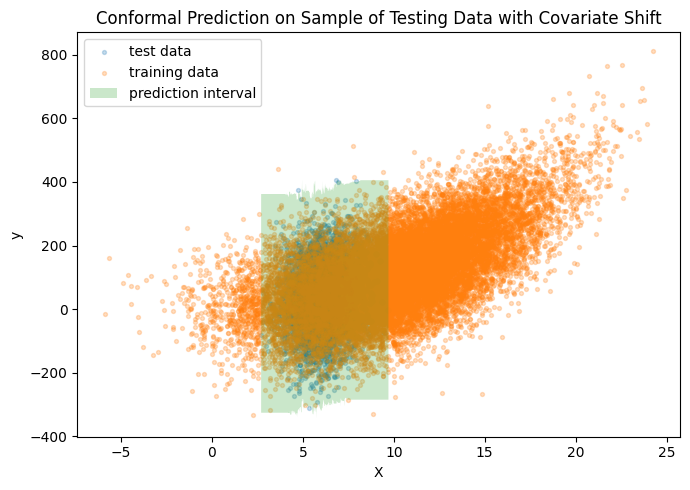

In [27]:
plt.figure(figsize=(7, 5))

# testing data (true function evaluated on sample_points)
plt.scatter(X_test.ravel(), y_test, s=8, alpha=0.25, label="test data")
plt.scatter(X_train.ravel(), y_train, s=8, alpha=0.25, label="training data")
plt.fill_between(x_grid.ravel(), pred_lower, pred_upper, alpha=0.25, label="prediction interval")

plt.xlabel("X")
plt.ylabel("y")
plt.title("Conformal Prediction on Sample of Testing Data with Covariate Shift")
plt.legend(loc="best")
plt.tight_layout()
plt.show()